In [1]:
%matplotlib inline

from __future__ import print_function, division
from collections import Counter

import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt

## Preprocessing Data

In [2]:
train_bodies = pd.read_csv('./data/train_bodies.csv')
train_stances = pd.read_csv('./data/train_stances.csv')
df_train = pd.merge(train_bodies, train_stances, on=['Body ID'])
print("%d Training Data"%len(df_train))
df_train.head()

49972 Training Data


,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [3]:
test_bodies = pd.read_csv('./data/competition_test_bodies.csv')
test_stances = pd.read_csv('./data/competition_test_stances.csv')
df_test = pd.merge(test_bodies, test_stances, on=['Body ID'])
print("%d Testing Data"%len(df_test))
df_test.head()

25413 Testing Data


,Body ID,articleBody,Headline,Stance
0,1,Al-Sisi has denied Israeli reports stating tha...,Apple installing safes in-store to protect gol...,unrelated
1,1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree
2,1,Al-Sisi has denied Israeli reports stating tha...,Apple to keep gold Watch Editions in special i...,unrelated
3,1,Al-Sisi has denied Israeli reports stating tha...,Apple Stores to Keep Gold “Edition” Apple Watc...,unrelated
4,1,Al-Sisi has denied Israeli reports stating tha...,South Korean woman's hair 'eaten' by robot vac...,unrelated


In [4]:
vocab = {
    'size': None,
    'word2idx': None,
}

data = {
    'train': {
        'headline': {
            'X': None,
            'X_tfidf': None,
        },
        'body': {
            'X': None,
            'X_tfidf': None,
        },
        'y': None,
    },
    'val': {
        'headline': {
            'X': None,
            'X_tfidf': None,
        },
        'body': {
            'X': None,
            'X_tfidf': None,
        },
        'y': None,
    },
    'test': {
        'headline': {
            'X': None,
            'X_tfidf': None,
        },
        'body': {
            'X': None,
            'X_tfidf': None,
        },
        'y': None,
    },
}

In [5]:
VOCAB_SIZE = 20000

def clean_str(text,
    filters="""!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n‘'’′-”–—£“"""):
    
    text = text.lower()
    
    translate_map = str.maketrans(filters, ' ' * len(filters))
    text = text.translate(translate_map)
    
    text = re.sub('[0-9]+', ' <number> ', text)
    text = re.sub('\s+', ' ', text)
    
    text = text.strip()
    
    return text

def pipe(df, vocab, make_vocab):
    t0 = time.time()
    m = {'headline': 'Headline', 'body': 'articleBody'}
    
    head_docum_list = df[m['headline']].values.tolist()
    head_docum_list = [clean_str(docum) for docum in head_docum_list]
    
    body_docum_list = df[m['body']].values.tolist()
    body_docum_list = [clean_str(docum) for docum in body_docum_list]
    
    if make_vocab:
        word2freq = Counter(' '.join(head_docum_list+body_docum_list).split())
        vocab['word2idx'] = {
            w: i for i, w in enumerate(['<pad>','<unk>'] + [w for w, freq in word2freq.most_common(VOCAB_SIZE)])}
        vocab['size'] = len(vocab['word2idx'])
    
    head_idx_list = [[vocab['word2idx'].get(w, 1) for w in d.split()] for d in head_docum_list]
    body_idx_list = [[vocab['word2idx'].get(w, 1) for w in d.split()] for d in body_docum_list]
    print("%.2f secs ==> pipe"%(time.time()-t0))
    
    return head_idx_list, body_idx_list


def make_y(df):
    label2idx = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
    return np.array([label2idx[label] for label in df['Stance'].values])

data['train']['headline']['X'], data['train']['body']['X'] = pipe(df_train, vocab, make_vocab=True)
data['train']['y'] = make_y(df_train)

data['test']['headline']['X'], data['test']['body']['X'] = pipe(df_test, vocab, make_vocab=False)
data['test']['y'] = make_y(df_test)

29.88 secs ==> pipe
11.24 secs ==> pipe


## Subtask 1

In [6]:
def train_test_split(*arrays, train_size=0.9):
    n_samples = len(arrays[0])
    cutoff = int(n_samples * train_size)
    return [(array[:cutoff], array[cutoff:]) for array in arrays]

def check_ratio(y):
    return ' '.join(['Label_%d: %.2f%% |'%(l, c/len(y)*100) for l, c in Counter(y).most_common()])

[(data['train']['headline']['X'], data['val']['headline']['X']),
 (data['train']['body']['X'], data['val']['body']['X']),
 (data['train']['y'], data['val']['y'])] = train_test_split(
    data['train']['headline']['X'], data['train']['body']['X'], data['train']['y'])

print('Training Data |', check_ratio(data['train']['y']))
print('Validation Data |', check_ratio(data['val']['y']))

Training Data | Label_3: 74.73% | Label_2: 16.68% | Label_0: 6.92% | Label_1: 1.67% |
Validation Data | Label_3: 58.74% | Label_2: 28.13% | Label_0: 11.30% | Label_1: 1.82% |


## Subtask 2

TFIDF

In [7]:
def build_tfidf(X):
    t0 = time.time()
    tf = np.zeros((len(X), vocab['size']))
    for i, indices in enumerate(X):
        for idx in indices:
            tf[i, idx] += (1 / len(indices))
    idf = np.sum(np.sign(tf), axis=0) # non-zero count
    idf = np.log10(len(X) / (idf + 1.))
    tfidf = tf * idf[np.newaxis, :]
    print("%.2f secs ==> build_tfidf"%(time.time()-t0))
    return tfidf

data['train']['headline']['X_tfidf'] = build_tfidf(data['train']['headline']['X'])
data['train']['body']['X_tfidf'] = build_tfidf(data['train']['body']['X'])
data['val']['headline']['X_tfidf'] = build_tfidf(data['val']['headline']['X'])
data['val']['body']['X_tfidf'] = build_tfidf(data['val']['body']['X'])
data['test']['headline']['X_tfidf'] = build_tfidf(data['test']['headline']['X'])
data['test']['body']['X_tfidf'] = build_tfidf(data['test']['body']['X'])

21.03 secs ==> build_tfidf
29.64 secs ==> build_tfidf
1.38 secs ==> build_tfidf
2.35 secs ==> build_tfidf
8.23 secs ==> build_tfidf
15.73 secs ==> build_tfidf


In [8]:
def cos_sim(vec1, vec2):
    return np.sum(np.multiply(vec1, vec2)) / (np.linalg.norm(vec1)*np.linalg.norm(vec2))

def cos_sim_feat(mat1, mat2):
    return np.array([cos_sim(vec1, vec2) for vec1, vec2 in zip(mat1, mat2)])

cos_sim_tfidf_train = cos_sim_feat(
    data['train']['headline']['X_tfidf'], data['train']['body']['X_tfidf'])
cos_sim_tfidf_val = cos_sim_feat(
    data['val']['headline']['X_tfidf'], data['val']['body']['X_tfidf'])
cos_sim_tfidf_test = cos_sim_feat(
    data['test']['headline']['X_tfidf'], data['test']['body']['X_tfidf'])
print('Cosine similarity: %.2f | Agrees'%(cos_sim_tfidf_train[data['train']['y']==0]).mean())
print('Cosine similarity: %.2f | Disagrees'%(cos_sim_tfidf_train[data['train']['y']==1]).mean())
print('Cosine similarity: %.2f | Discusses'%(cos_sim_tfidf_train[data['train']['y']==2]).mean())
print('Cosine similarity: %.2f | Unrelated'%(cos_sim_tfidf_train[data['train']['y']==3]).mean())

Cosine similarity: 0.25 | Agrees
Cosine similarity: 0.23 | Disagrees
Cosine similarity: 0.23 | Discusses
Cosine similarity: 0.01 | Unrelated


## Subtask 3

cross entropy between language models

In [9]:
def unigram(sent):
    lm = {w: c/len(sent) for w, c in Counter(sent).items()}
    return lm

def kl_feat(headlines, bodys):
    kl_div = []
    for headline, body in zip(headlines, bodys):
        temp = 0
        lm_headline = unigram(headline)
        lm_body = unigram(body)
        for w, proba in lm_headline.items():
            temp -= proba * np.log(lm_body.get(w, 1e-8))
        kl_div.append(temp / len(lm_headline))
    return np.array(kl_div)

kl_div_train = kl_feat(data['train']['headline']['X'], data['train']['body']['X'])
kl_div_val = kl_feat(data['val']['headline']['X'], data['val']['body']['X'])
kl_div_test = kl_feat(data['test']['headline']['X'], data['test']['body']['X'])

print('KL: %.2f | Agrees'%(kl_div_train[data['train']['y']==0]).mean())
print('KL: %.2f | Disagrees'%(kl_div_train[data['train']['y']==1]).mean())
print('KL: %.2f | Discusses'%(kl_div_train[data['train']['y']==2]).mean())
print('KL: %.2f | Unrelated'%(kl_div_train[data['train']['y']==3]).mean())

KL: 0.89 | Agrees
KL: 0.90 | Disagrees
KL: 0.93 | Discusses
KL: 1.53 | Unrelated


## Subtask 4

Common Word Count

In [10]:
def common_count(list_1, list_2):
    return len(list(set(list_1).intersection(list_2)))

def common_count_feat(mat1, mat2):
    return np.array([common_count(vec1, vec2) for vec1, vec2 in zip(mat1, mat2)])

In [11]:
common_count_train = common_count_feat(data['train']['headline']['X'], data['train']['body']['X'])
common_count_val = common_count_feat(data['val']['headline']['X'], data['val']['body']['X'])
common_count_test = common_count_feat(data['test']['headline']['X'], data['test']['body']['X'])

print('Common count: %.2f | Agrees'%(common_count_train[data['train']['y']==0]).mean())
print('Common count: %.2f | Disagrees'%(common_count_train[data['train']['y']==1]).mean())
print('Common count: %.2f | Discusses'%(common_count_train[data['train']['y']==2]).mean())
print('Common count: %.2f | Unrelated'%(common_count_train[data['train']['y']==3]).mean())

Common count: 7.82 | Agrees
Common count: 7.54 | Disagrees
Common count: 7.50 | Discusses
Common count: 2.72 | Unrelated


Euclidean Distance

In [12]:
def e_dist(vec1, vec2):
    return np.sqrt(np.sum(np.square((vec1 - vec2))))

def e_dist_feat(mat1, mat2):
    return np.array([e_dist(vec1, vec2) for vec1, vec2 in zip(mat1, mat2)])

e_dist_tfidf_train = e_dist_feat(data['train']['headline']['X_tfidf'], data['train']['body']['X_tfidf'])
e_dist_tfidf_val = e_dist_feat(data['val']['headline']['X_tfidf'], data['val']['body']['X_tfidf'])
e_dist_tfidf_test = e_dist_feat(data['test']['headline']['X_tfidf'], data['test']['body']['X_tfidf'])

print('Euclidean Distance: %.2f | Agrees'%(e_dist_tfidf_train[data['train']['y']==0]).mean())
print('Euclidean Distance: %.2f | Disagrees'%(e_dist_tfidf_train[data['train']['y']==1]).mean())
print('Euclidean Distance: %.2f | Discusses'%(e_dist_tfidf_train[data['train']['y']==2]).mean())
print('Euclidean Distance: %.2f | Unrelated'%(e_dist_tfidf_train[data['train']['y']==3]).mean())

Euclidean Distance: 0.62 | Agrees
Euclidean Distance: 0.61 | Disagrees
Euclidean Distance: 0.58 | Discusses
Euclidean Distance: 0.62 | Unrelated


## Subtask 5

In [13]:
def box_plot(data, labels, y_name):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(data)
    ax.set_xticklabels(labels)
    ax.set_title(y_name)

TF-IDF

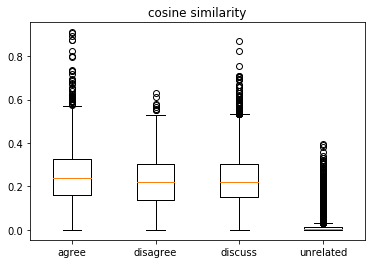

In [14]:
box_plot([cos_sim_tfidf_train[data['train']['y']==0], cos_sim_tfidf_train[data['train']['y']==1],
          cos_sim_tfidf_train[data['train']['y']==2], cos_sim_tfidf_train[data['train']['y']==3]],
          ['agree', 'disagree', 'discuss', 'unrelated'], 'cosine similarity')

KL Divergence

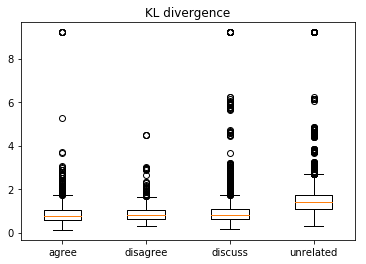

In [15]:
box_plot([kl_div_train[data['train']['y']==0], kl_div_train[data['train']['y']==1],
          kl_div_train[data['train']['y']==2], kl_div_train[data['train']['y']==3]],
          ['agree', 'disagree', 'discuss', 'unrelated'], 'KL divergence')

## Subtask 6

In [16]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

class LogisticRegression:
    def __init__(self, lr=1e-3):
        self.lr = lr
    
    def init_weight(self, m):
        self.W = np.random.randn(m, 1)
        self.b = 0.01
    
    def fit(self, X, y, steps):
        self.init_weight(X.shape[1])
        costs = []
        for i in range(steps):
            y_ = self.forward(X)
            cost = self.backward(X, y, y_)
            costs.append(cost)
        return costs
            
    def predict(self, X):
        return self.forward(X)
    
    def forward(self, X):
        return sigmoid(X @ self.W + self.b)
    
    def backward(self, X, y, y_):
        m = X.shape[0]
        cost = (-1.0 / m) * np.sum(y * np.log(y_) + (1-y) * np.log(1-y_))
        dz = y_ - y
        dW = (1.0 / m) * X.T @ dz
        db = (1.0 / m) * dz.sum()
        self.W = self.W - self.lr * dW
        self.b = self.b - self.lr * db
        return cost

## Subtask 7

In [17]:
def scale(mat):
    return (mat - np.mean(mat, axis=0)) / np.std(mat, axis=0)

X_train = np.concatenate([
    cos_sim_tfidf_train[:, np.newaxis],
    common_count_train[:, np.newaxis],
    e_dist_tfidf_train[:, np.newaxis],
    kl_div_train[:, np.newaxis],
], axis=1)

X_val = np.concatenate([
    cos_sim_tfidf_val[:, np.newaxis],
    common_count_val[:, np.newaxis],
    e_dist_tfidf_val[:, np.newaxis],
    kl_div_val[:, np.newaxis],
], axis=1)

X_test = np.concatenate([
    cos_sim_tfidf_test[:, np.newaxis],
    common_count_test[:, np.newaxis],
    e_dist_tfidf_test[:, np.newaxis],
    kl_div_test[:, np.newaxis],
], axis=1)

X_train = scale(X_train)
X_val = scale(X_val)
X_test = scale(X_test)

In [18]:
def to_one_hot(y, num_classes):
    n = y.shape[0]
    one_hot = np.zeros((n, num_classes), dtype=np.float32)
    one_hot[np.arange(n), y] = 1
    return one_hot

y_train = to_one_hot(data['train']['y'], 4)
y_val = to_one_hot(data['val']['y'], 4)
y_test = to_one_hot(data['test']['y'], 4)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(44974, 4) (44974, 4) (4998, 4) (4998, 4) (25413, 4) (25413, 4)


In [19]:
from sklearn.metrics import classification_report

def down_sampling(X, y):
    y_pos, y_neg, X_pos, X_neg = y[y==1], y[y==0], X[y==1], X[y==0]
    if len(y_pos) < len(y_neg):
        X_ = np.concatenate([X_pos, X_neg[:len(y_pos)]], 0)
        y_ = np.concatenate([y_pos, y_neg[:len(y_pos)]])
    else:
        X_ = np.concatenate([X_pos[:len(y_neg)], X_neg], 0)
        y_ = np.concatenate([y_pos[:len(y_neg)], y_neg])
    return X_, y_

def evaluation(clfs):
    y_test_pred = []
    for i in range(4):
        clf = clfs[i]
        _X_train, _y_train = down_sampling(X_train, y_train[:, i])
        costs = clf.fit(_X_train, _y_train[:, np.newaxis], steps=20000)
        y_test_pred.append(clf.predict(X_test))
        plt.plot(costs, label='class %d'%i)
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')
    y_test_pred = np.argmax(np.concatenate(y_test_pred, -1), -1)
    print('Test Set Accuracy: %.3f' % ((y_test_pred==data['test']['y']).mean()))
    print()
    print(classification_report(data['test']['y'], y_test_pred,
                                target_names=['agree','disagree','discuss','unrelated']))

Test Set Accuracy: 0.796

             precision    recall  f1-score   support

      agree       0.24      0.40      0.30      1903
   disagree       0.13      0.16      0.14       697
    discuss       0.67      0.44      0.53      4464
  unrelated       0.94      0.95      0.94     18349

avg / total       0.82      0.80      0.80     25413



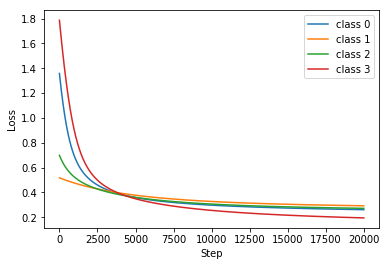

In [20]:
evaluation([LogisticRegression()]*4)